# Frozen Lake

### Описание задачи

**Характеристики игры**  
* Эпизодическая среда
* Стохастическая / Детерминированная среда
* Дискретная среда
* Среда с полной информацией

**Цель игры**  
Необходимо перейти из начального состояния **S** в целевое состояние **G**,<br> пройдя только по льду **F** и избегая полыньи **H**.<br>
Однако лед скользкий, поэтому вы не всегда будете двигаться в нужном направлении.

**Окружение**

<img src="http://simoninithomas.com/drlc/Qlearning/frozenlake4x4.png" />

**Пространство действий**

* Пойти направо
* Пойти налево
* Пойти вверх
* Пойти вниз

**Терминальные состояния**  
Эпизод заканчивается, когда вы достигаете цели или попадаете в полынью.

**Функция вознаграждения**  
Вы получаете вознаграждение в размере 1, если вы достигнете цели, и ноль в противном случае.

**Полезные ссылки**
* https://gymnasium.farama.org/environments/toy_text/frozen_lake
* https://gymnasium.farama.org/tutorials/training_agents/FrozenLake_tuto




***

### Установка зависимостей, импорт библиотек

**Установка зависимостей**

In [ ]:
!pip install gymnasium

**Импорт библиотек**

In [3]:
!pip install google.colab

ERROR: Could not find a version that satisfies the requirement google.colab (from versions: none)
ERROR: No matching distribution found for google.colab

[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import os
import sys
import PIL
import time
import json
import random
import numpy as np
import pandas as pd
import shutil as sh
from glob import glob
from pytz import timezone
from datetime import datetime
from collections import deque
from base64 import b64encode
from matplotlib import pyplot as plt
from IPython.display import display, clear_output, HTML
import seaborn as sns
from collections import defaultdict

In [7]:
import gymnasium as gym

### Подключение Google диска

### Выбор временной зоны

In [8]:
TZ = timezone('Europe/Moscow')

### Определение путей и директорий

In [14]:
env_dir = "D:\RL_course\DynaQ\content"
scenarios_dir = os.path.join(env_dir, 'scenarios')

In [15]:
if not os.path.exists(scenarios_dir):
    os.makedirs(scenarios_dir)

### Вспомогательные методы

**Отображение состояния среды, сохранение записи эпизода, просмотр записи эпизода**

In [16]:
def display_state(state):
    plt.figure(figsize=(6, 6))
    plt.imshow(state)
    plt.axis('off')


def record_episode(eps_frames, records_dir, agent_name, exp_id, eps_num):
    record_path = os.path.join(records_dir, f'{agent_name}_{exp_id}_eps-{eps_num}.mp4')
    eps_frame_dir = 'episode_frames'
    os.mkdir(eps_frame_dir)

    for i, frame  in enumerate(eps_frames):
        PIL.Image.fromarray(frame).save(os.path.join(eps_frame_dir, f'frame-{i+1}.png'))

    os.system(f'ffmpeg -r 2 -i {eps_frame_dir}/frame-%1d.png -vcodec libx264 -b 10M -y "{record_path}"');
    sh.rmtree(eps_frame_dir)


def show_episode_records(records_dir):
    record_paths = glob(os.path.join(records_dir, "*.mp4"))
    html_str = ''
    for i, record_path in enumerate(record_paths):
        mp4 = open(record_path, 'rb').read()
        data = f"data:video/mp4;base64,{b64encode(mp4).decode()}"
        html_str += f'EPISODE # {i+1}<br><video width=500 controls><source src="{data}" type="video/mp4"></video><br><br>'
    return HTML(html_str)


**Создание директорий для логирования результатов, сохрание параметров и метрик экспериментов**

In [17]:
def create_exp_dirs(scenarios_dir, exp_params):
    dirs = dict()
    dirs['exp'] = os.path.join(scenarios_dir, exp_params["scenario_name"], exp_params["algorithm_name"], exp_params["exp_id"])
    dirs['training'] = os.path.join(dirs['exp'], 'training')
    dirs['evaluation'] = os.path.join(dirs['exp'], 'evaluation')
    os.makedirs(dirs['training'], exist_ok=True)
    os.makedirs(dirs['evaluation'], exist_ok=True)
    return dirs


def save_exp_params(params, exp_dir):
    params_path = os.path.join(exp_dir, 'experiment_params.json')
    with open(params_path, 'w') as f:
        json.dump(params, f)


def save_metrics(metrics, metrics_type, train_eps_dir):
    metrics_path = os.path.join(train_eps_dir, f'{metrics_type}_metrics.json')
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f)

**Построение графика процесса валидации для выбранных экспериментов**

In [18]:
def display_validation_plot(scenarios_dir, scenario_name, exp_ids):
    fig = plt.figure(figsize=(10, 6))
    earliest_validation_eps = np.inf
    max_training_eps_count = 0

    for model_name in exp_ids.keys():
        for exp_id in exp_ids[model_name]:
            exp_dir = os.path.join(scenarios_dir, scenario_name, model_name, exp_id)
            exp_params_path = os.path.join(exp_dir, 'experiment_params.json')
            training_dir = os.path.join(exp_dir, 'training')

            with open(exp_params_path, 'r') as f:
                exp_params = json.load(f)
            total_eps_count = exp_params['training']['episode_count']
            validation_step = exp_params['validation']['validate_agent_every_n_eps']
            if total_eps_count > max_training_eps_count:
                max_training_eps_count = total_eps_count
            if validation_step < earliest_validation_eps:
                earliest_validation_eps = validation_step

            exp_win_shares = list()
            for iter_name in os.listdir(training_dir):
                iter_metrics_path = os.path.join(training_dir, iter_name, 'training_iter_metrics.json')
                with open(iter_metrics_path, 'r') as f:
                    iter_metrics = json.load(f)
                exp_win_shares.append(iter_metrics['win_share'])

            iter_means = np.mean(exp_win_shares, axis=0).round(3)
            iter_stds = np.std(exp_win_shares, axis=0).round(3)
            std_bounds = np.array([[avg - std, avg + std] for avg, std in list(zip(iter_means, iter_stds))])
            validation_steps = range(validation_step, total_eps_count + validation_step, validation_step)

            plt.plot(validation_steps, iter_means, label=f'{model_name} ({exp_id})')
            plt.fill_between(validation_steps, std_bounds[:,0], std_bounds[:,1], alpha=.3)

    plt.xlim(earliest_validation_eps, max_training_eps_count)
    plt.ylim(0, 1)
    plt.xlabel('Training episodes')
    plt.ylabel('Win share')
    plt.title(f'Сomparative assessment of learning process ({scenario_name})')
    plt.legend(loc='upper left')
    plt.grid()

**Загрузка лучшего агента из всех итераций для выбранного шага обучения**

In [19]:
def load_best_agent_for_train_step(train_eps_num, iteration_count, training_dir, agent):
    best_iter_num = 1
    best_win_share = 0
    best_avg_step_count = 100
    for iter_num in range(1, iteration_count+1):
        iter_dir = os.path.join(training_dir, f'iter-{iter_num}')
        eps_dir = os.path.join(iter_dir, f'eps-{train_eps_num}')
        val_metrics_path = os.path.join(eps_dir, 'validation_metrics.json')
        with open(val_metrics_path, 'r') as f:
            val_metrics = json.load(f)
        if val_metrics['win_share'] > best_win_share and val_metrics['avg_step_count'] < best_avg_step_count:
            best_iter_num = iter_num
            best_win_share = val_metrics['win_share']
            best_avg_step_count = val_metrics['avg_step_count']

    agent_state_dir = os.path.join(training_dir, f'iter-{best_iter_num}', f'eps-{train_eps_num}')
    agent.load_agent_state(agent_state_dir)

## Обзор окружения

In [21]:
MAP_SIZE = 8
STOCHASTIC_ENV = False
ACTION_MAP = {
    'L': 0,
    'D': 1,
    'R': 2,
    'U': 3
}

def create_environment(map_size, stochastic_env):
    return gym.make('FrozenLake-v1', map_name=f'{map_size}x{map_size}', is_slippery=stochastic_env, render_mode='rgb_array')


### Создание окружения, старт нового эпизода, отображение начального состояния

Current state: 0


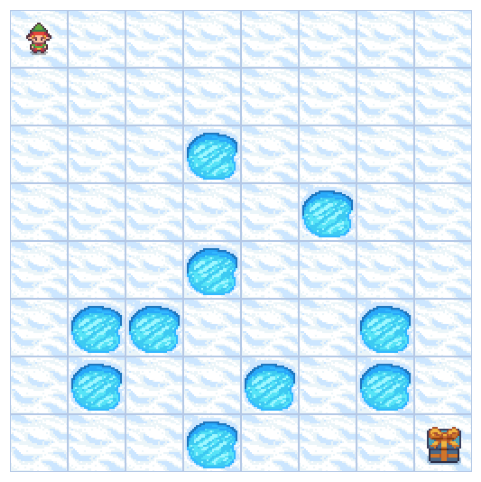

In [22]:
env = create_environment(map_size=MAP_SIZE, stochastic_env=STOCHASTIC_ENV)
state, info = env.reset()
state_rgb = env.render()

print(f'Current state: {state}')
display_state(state_rgb)

### Тестирование окружения

Current state: 8
Reward: 0.0
Done: (False, False)


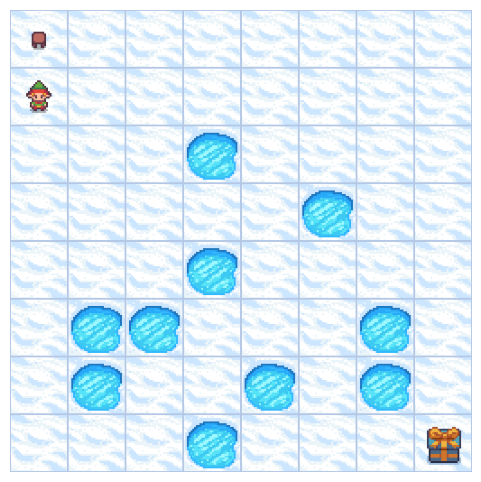

In [23]:
action_name = 'D'
action = ACTION_MAP[action_name]

next_state, reward, terminated, truncated, info = env.step(action)
next_state_rgb = env.render()

print(f'Current state: {next_state}\nReward: {reward}\nDone: {terminated, truncated}')
display_state(next_state_rgb)

In [24]:
env.close()

## Тестирование агента со случайной стратегией

### Случайный агент

In [25]:
class RandomAgent:

  def __init__(self, env, params):
      self._env = env
      self._params = params

  @property
  def name(self):
      return f"{self._params['algorithm_name']}_agent"

  def choose_action(self, state, mode='exploitation'):
      return self._env.action_space.sample()

### Методы для запуска эпизодов и оценки агента

In [26]:
def run_episode(env, agent):
    state, info = env.reset()
    step_count = 0
    frames = list()
    done = False

    while not done:
        action = agent.choose_action(state, mode='exploitation')
        next_state, reward, terminated, truncated, info = env.step(action)
        frames.append(env.render())
        done = terminated or truncated
        state = next_state
        step_count += 1

    frames.extend([env.render()] * 3)
    return state, step_count, frames


def evaluate_agent(env, agent, exp_params, exp_dirs):
    for eps_num in range(1, exp_params['evaluation']['episode_count'] + 1):
        eps_final_state, eps_step_count, eps_frames = run_episode(env, agent)
        record_episode(eps_frames, exp_dirs['evaluation'], exp_params['algorithm_name'], exp_params['exp_id'], eps_num)

        print(f'EPISODE # {eps_num}')
        if eps_final_state == env.observation_space.n - 1:
            print('Agent reached the Goal 🏆')
        else:
            print('Agent was defeated ☠️')
        print(f'Number of steps: {eps_step_count}')
        print('-' * 50)

### Параметры эксперимента

In [27]:
exp_params = {
    'scenario_name': f'{MAP_SIZE}x{MAP_SIZE}_{"stochastic" if STOCHASTIC_ENV else "deterministic"}',
    'algorithm_name': 'random',
    'exp_id': f'exp-{datetime.now(TZ).strftime("%d%m-%H%M%S")}',
    'seed': 21,
    'evaluation': {
        'episode_count': 3
    }
}

exp_dirs = create_exp_dirs(scenarios_dir, exp_params)
save_exp_params(exp_params, exp_dirs['exp'])

### Оценка агента

In [28]:
env = create_environment(map_size=MAP_SIZE, stochastic_env=STOCHASTIC_ENV)
random_agent = RandomAgent(env, exp_params)
evaluate_agent(env, random_agent, exp_params, exp_dirs)
env.close()

EPISODE # 1
Agent was defeated ☠️
Number of steps: 45
--------------------------------------------------
EPISODE # 2
Agent was defeated ☠️
Number of steps: 20
--------------------------------------------------
EPISODE # 3
Agent was defeated ☠️
Number of steps: 14
--------------------------------------------------


In [29]:
show_episode_records(exp_dirs['evaluation'])

## Тестирование Q-агента в детерминированной среде

In [30]:
MAP_SIZE = 8
STOCHASTIC_ENV = False

### Реализация агента

In [31]:
class QAgent:

    def __init__(self, env, params):
        self._env = env
        self._params = params
        self._epsilon = params['training']['epsilon']
        self._qtable = np.zeros((env.observation_space.n, env.action_space.n))
        self._action_arrow_map = { 0: '', 1: '←', 2: '↓', 3: '→', 4: '↑' }

    @property
    def name(self):
        return f"{self._params['algorithm_name']}_agent"

    @property
    def exploration_level(self):
        return self._epsilon


    def choose_action(self, state, mode='exploitation'):
        if mode == 'exploration':
          if np.random.rand() < self._epsilon:
              return self._env.action_space.sample()

        return np.argmax(self._qtable[state, :])


    def learn(self, state, action, next_state, reward):
        target = reward + self._params['training']['gamma'] * np.max(self._qtable[next_state, :])
        self._qtable[state, action] = self._qtable[state, action] + \
                                      self._params['training']['learning_rate'] * (target - self._qtable[state, action])


    def decrease_exploration_level(self):
        if self._epsilon > self._params['training']['epsilon_min']:
            self._epsilon *= self._params['training']['epsilon_decay_rate']


    def display_q_table(self):
        self._prepare_q_table()


    def save_q_table_as_plot(self, eps_dir):
        q_table_plot = self._prepare_q_table()
        q_table_plot_path = os.path.join(eps_dir, 'qtable.png')
        q_table_plot.savefig(q_table_plot_path, bbox_inches='tight')
        plt.close(q_table_plot)


    def save_agent_state(self, eps_dir):
        qtable_path = os.path.join(eps_dir, 'qtable.npy')
        np.save(qtable_path, self._qtable)


    def load_agent_state(self, eps_dir):
        qtable_path = os.path.join(eps_dir, 'qtable.npy')
        self._qtable = np.load(qtable_path, allow_pickle=True)


    def _prepare_q_table(self):
        greedy_values = np.max(self._qtable, axis=1).reshape(MAP_SIZE, MAP_SIZE)
        greedy_actions = np.argmax(np.hstack((np.zeros((self._env.observation_space.n, 1)), self._qtable)), axis=1)
        greedy_actions_arrows = np.array(list(map(lambda x: '' if x == 0 else self._action_arrow_map[x], greedy_actions))).reshape(MAP_SIZE, MAP_SIZE)

        fig = plt.figure()
        sns.heatmap(greedy_values,
                    annot=greedy_actions_arrows,
                    annot_kws={"fontsize": 16},
                    fmt = '',
                    cmap="YlGnBu",
                    linewidths=.5)
        plt.axis('off')
        return fig


### Методы для тренировки и валидации агента

In [32]:
def train_agent(env, agent, exp_params, exp_dirs, enable_eps_recording):
    random.seed(exp_params['seed'])
    np.random.seed(exp_params['seed'])

    train_iter_count = len(os.listdir(exp_dirs['training']))
    train_iter_dir = os.path.join(exp_dirs['training'], f'iter-{train_iter_count+1}')
    os.mkdir(train_iter_dir)

    training_eps_count = exp_params['training']['episode_count']
    validate_agent_every_n_eps = exp_params['validation']['validate_agent_every_n_eps']
    validation_eps_count = exp_params['validation']['episode_count']

    train_metrics = {
        'total_eps_count': training_eps_count,
        'validation_step': validate_agent_every_n_eps,
        'win_share': []
    }

    for eps_num in range(1, training_eps_count + 1):
        state, info = env.reset()
        done = False

        while not done:
            action = agent.choose_action(state, mode='exploration')
            next_state, reward, terminated, truncated, info = env.step(action)
            agent.learn(state, action, next_state, reward)
            done = terminated or truncated
            state = next_state

        agent.decrease_exploration_level()

        if eps_num % validate_agent_every_n_eps == 0:
            eps_dir = os.path.join(train_iter_dir, f'eps-{eps_num}')
            os.mkdir(eps_dir)

            val_metrics = validate_agent(env, agent, exp_params, eps_dir, enable_eps_recording)
            train_metrics['win_share'].append(val_metrics['win_share'])
            agent.save_q_table_as_plot(eps_dir)
            agent.save_agent_state(eps_dir)

            print(f"EPISODE # {eps_num} / {training_eps_count}")
            print(f"Win share ({validation_eps_count} eps): {val_metrics['win_share']}")
            print(f"Avg step count ({validation_eps_count} eps): {val_metrics['avg_step_count']}")
            print(f"Aget exploration level (epsilon): {val_metrics['exploration_level']}")
            print('-' * 50)

    save_metrics(train_metrics, 'training_iter', train_iter_dir)
    return train_metrics


def validate_agent(env, agent, exp_params, train_eps_dir, enable_eps_recording):
    validation_eps_count = exp_params['validation']['episode_count']
    won_eps_count = 0
    eps_step_counts = list()

    for eps_num in range(1, validation_eps_count + 1):
        eps_final_state, eps_step_count, eps_frames = run_episode(env, agent)
        if eps_final_state == env.observation_space.n - 1:
            won_eps_count += 1
        eps_step_counts.append(eps_step_count)
        if enable_eps_recording:
            record_episode(eps_frames, train_eps_dir, exp_params['algorithm_name'], exp_params['exp_id'], eps_num)

    val_metrics = {
        'win_share': round(won_eps_count / validation_eps_count, 3),
        'avg_step_count': round(sum(eps_step_counts) / validation_eps_count, 3),
        'exploration_level': round(agent.exploration_level, 3)
    }

    save_metrics(val_metrics, 'validation', train_eps_dir)
    return val_metrics

### Параметры эксперимента

In [33]:
exp_params = {
    'scenario_name': f'{MAP_SIZE}x{MAP_SIZE}_{"stochastic" if STOCHASTIC_ENV else "deterministic"}',
    'algorithm_name': 'qtable',
    'exp_id': f'exp-{datetime.now(TZ).strftime("%d%m-%H%M%S")}',
    'seed': 21,
    'training': {
        'iteration_count': 1,
        'episode_count': 5000,
        'learning_rate': 0.05,
        'gamma': 0.99,
        'epsilon': 1.0,
        'epsilon_min': 0.01,
        'epsilon_decay_rate': 0.99995
    },
    'validation': {
        'validate_agent_every_n_eps': 500,
        'episode_count': 10
    },
    'evaluation': {
        'episode_count': 3
    }
}

exp_dirs = create_exp_dirs(scenarios_dir, exp_params)
save_exp_params(exp_params, exp_dirs['exp'])

### Обучение агента

In [34]:
env = create_environment(map_size=MAP_SIZE, stochastic_env=STOCHASTIC_ENV)

for iter_num in range(1, exp_params['training']['iteration_count']+1):
    print(f'TRAINING ITERATION # {iter_num}\n')
    qtable_agent = QAgent(env, exp_params)
    train_agent(env, qtable_agent, exp_params, exp_dirs, enable_eps_recording=True)
    if iter_num != exp_params['training']['iteration_count']:
        clear_output()

env.close()

TRAINING ITERATION # 1

EPISODE # 500 / 5000
Win share (10 eps): 0.0
Avg step count (10 eps): 100.0
Aget exploration level (epsilon): 0.975
--------------------------------------------------
EPISODE # 1000 / 5000
Win share (10 eps): 0.0
Avg step count (10 eps): 100.0
Aget exploration level (epsilon): 0.951
--------------------------------------------------
EPISODE # 1500 / 5000
Win share (10 eps): 0.0
Avg step count (10 eps): 100.0
Aget exploration level (epsilon): 0.928
--------------------------------------------------
EPISODE # 2000 / 5000
Win share (10 eps): 0.0
Avg step count (10 eps): 100.0
Aget exploration level (epsilon): 0.905
--------------------------------------------------
EPISODE # 2500 / 5000
Win share (10 eps): 0.0
Avg step count (10 eps): 100.0
Aget exploration level (epsilon): 0.882
--------------------------------------------------
EPISODE # 3000 / 5000
Win share (10 eps): 1.0
Avg step count (10 eps): 14.0
Aget exploration level (epsilon): 0.861
---------------------

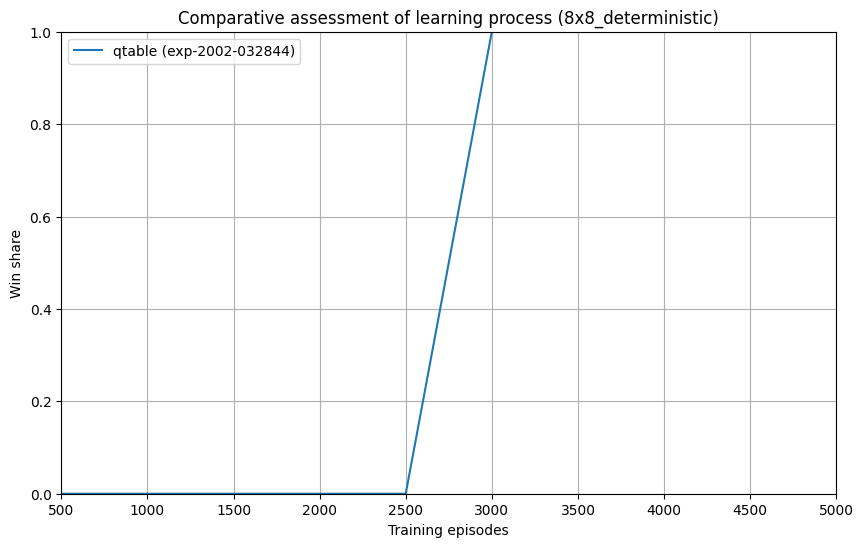

In [35]:
scenario_name = exp_params['scenario_name']
exp_ids = {
    exp_params['algorithm_name']: [exp_params['exp_id']]
}

display_validation_plot(scenarios_dir, scenario_name, exp_ids)

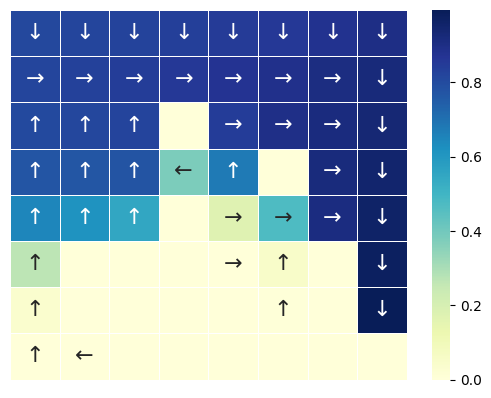

In [36]:
qtable_agent.display_q_table()

### Оценка агента

In [37]:
env = create_environment(map_size=MAP_SIZE, stochastic_env=STOCHASTIC_ENV)
evaluate_agent(env, qtable_agent, exp_params, exp_dirs)
env.close()

EPISODE # 1
Agent reached the Goal 🏆
Number of steps: 14
--------------------------------------------------
EPISODE # 2
Agent reached the Goal 🏆
Number of steps: 14
--------------------------------------------------
EPISODE # 3
Agent reached the Goal 🏆
Number of steps: 14
--------------------------------------------------


In [38]:
show_episode_records(exp_dirs['evaluation'])

## Тестирование DynaQ-агента в детерминированной среде

In [39]:
MAP_SIZE = 8
STOCHASTIC_ENV = False

### Описаниа алгоритма Dyna-Q



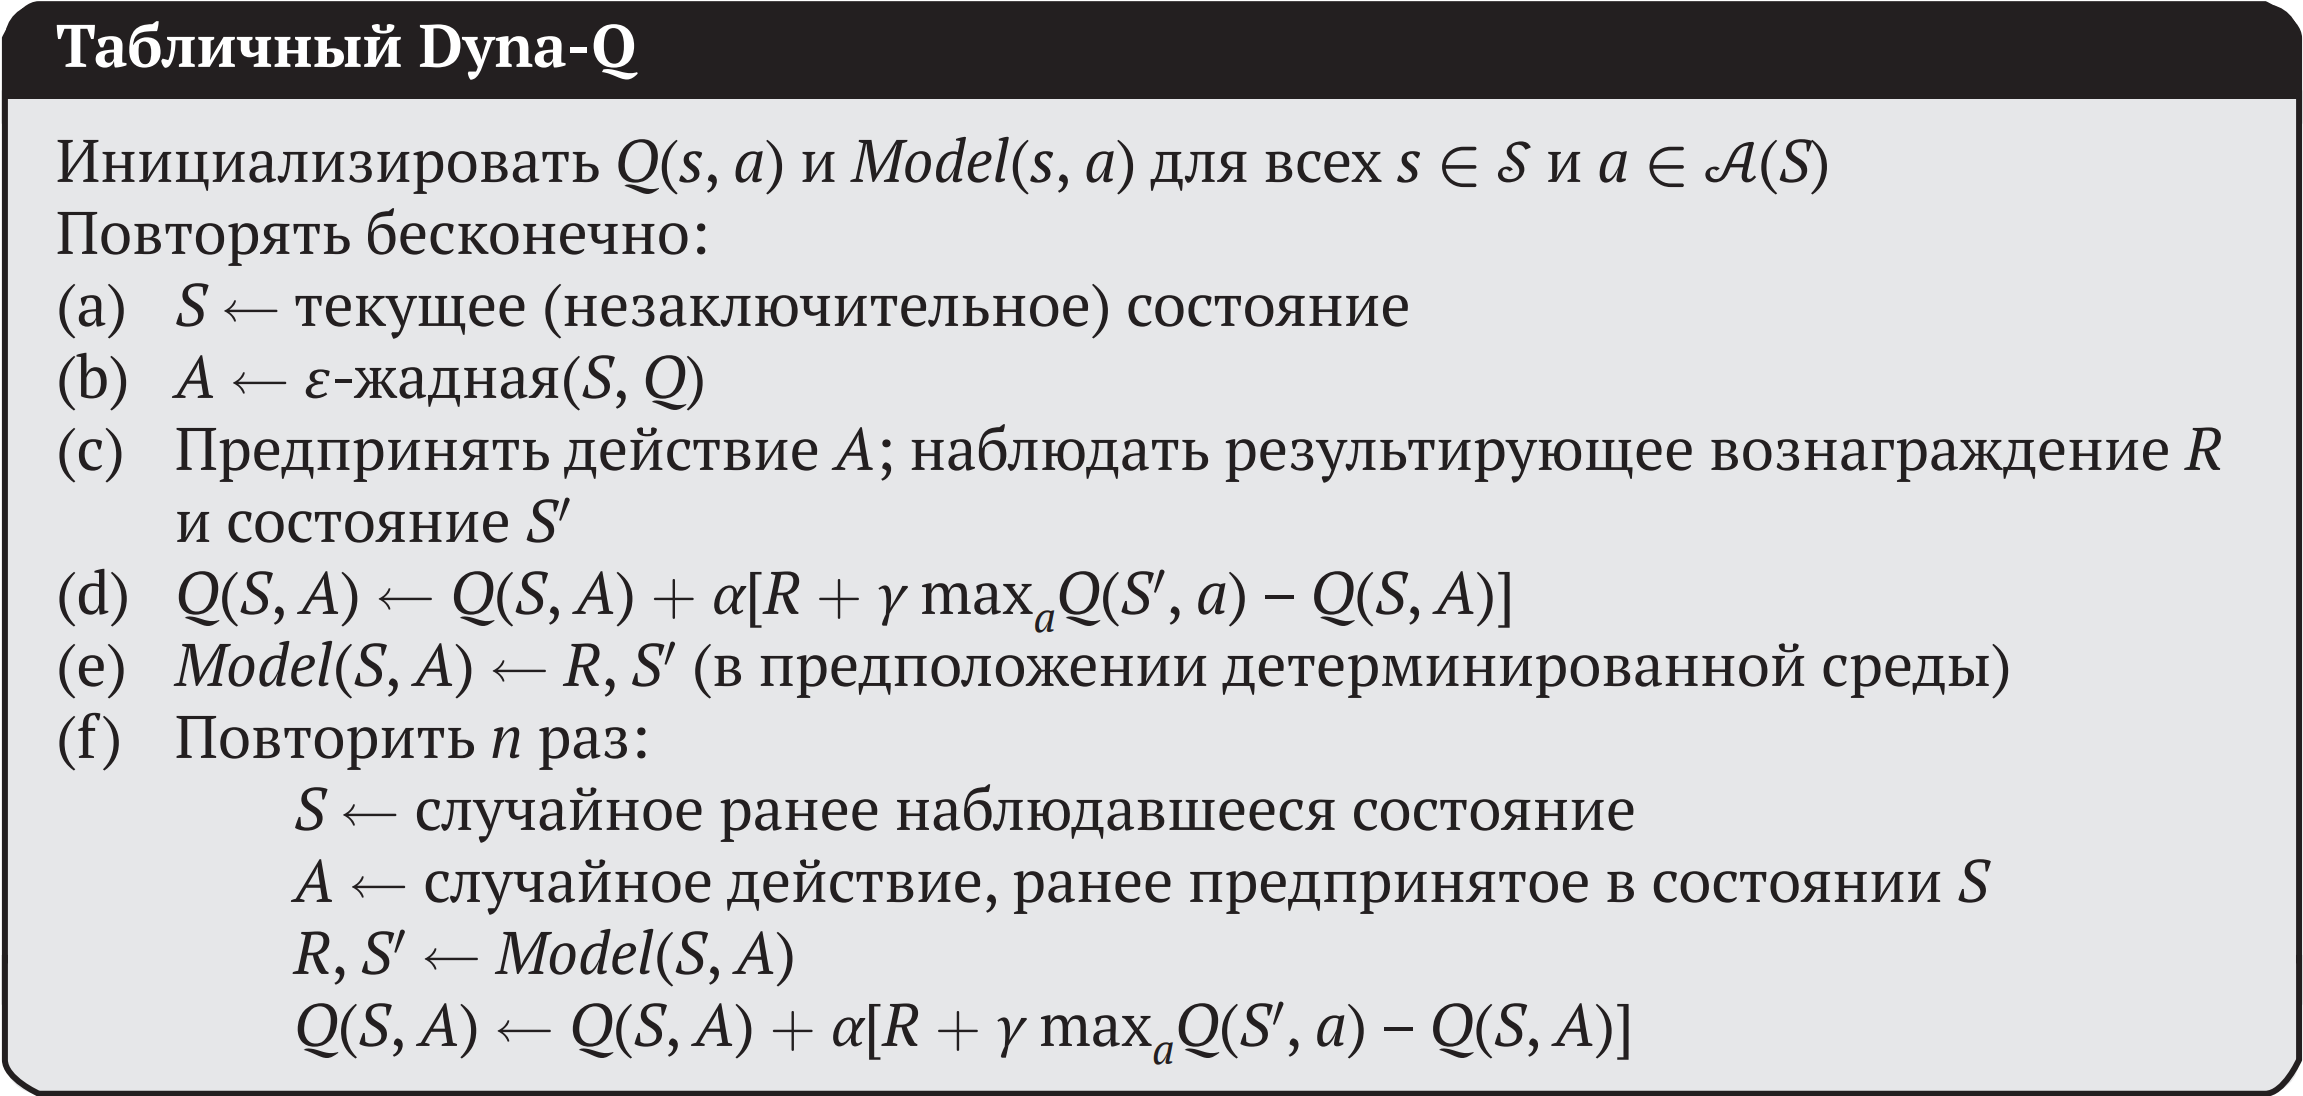

### Реализация модели окружения

In [40]:
class DeterministicEnvModel:

    def __init__(self, n_states, n_actions):
        self.n_states = n_states
        self.n_actions = n_actions
        self.completed_transitions = set()
        self.transitions = np.zeros((n_states, n_actions), dtype=np.uint8)
        self.rewards = np.zeros((n_states, n_actions), dtype=np.uint8)


    def update(self, state, action, next_state, reward):
        if (state, action) not in self.completed_transitions:
            self.completed_transitions.add((state, action))
            self.transitions[state, action] = next_state
            self.rewards[state, action] = reward


    def sample(self):
        return random.choice(list(self.completed_transitions))


    def step(self, state, action):
        next_state = self.transitions[state, action]
        reward = self.rewards[state, action]
        return next_state, reward


    def display_transitions(self):
        display(HTML(pd.DataFrame(self.transitions, columns=['L', 'D', 'R', 'U']).T.to_html()))


    def display_rewards(self):
        display(HTML(pd.DataFrame(self.rewards, columns=['L', 'D', 'R', 'U']).T.to_html()))

### Реализация агента

In [41]:
class DynaQAgent:

    def __init__(self, env, env_model_cls, params):
        self._env = env
        self._params = params
        self._epsilon = params['training']['epsilon']
        self._qtable = np.zeros((env.observation_space.n, env.action_space.n))
        self._model = env_model_cls(env.observation_space.n, env.action_space.n)
        self._action_arrow_map = { 0: '', 1: '←', 2: '↓', 3: '→', 4: '↑' }

    @property
    def name(self):
        return f"{self._params['algorithm_name']}_agent"

    @property
    def exploration_level(self):
        return self._epsilon


    def choose_action(self, state, mode='exploitation'):
        if mode == 'exploration':
          if np.random.rand() < self._epsilon:
              return self._env.action_space.sample()

        return np.argmax(self._qtable[state, :])


    def learn(self, state, action, next_state, reward):
        self._learn(state, action, next_state, reward)
        self._update_model(state, action, next_state, reward)
        self._planning(self._params['training']['planning_steps'])


    def decrease_exploration_level(self):
        if self._epsilon > self._params['training']['epsilon_min']:
            self._epsilon *= self._params['training']['epsilon_decay_rate']


    def display_q_table(self):
        self._prepare_q_table()


    def save_q_table_as_plot(self, eps_dir):
        q_table_plot = self._prepare_q_table()
        q_table_plot_path = os.path.join(eps_dir, 'qtable.png')
        q_table_plot.savefig(q_table_plot_path, bbox_inches='tight')
        plt.close(q_table_plot)


    def display_model(self):
        print(f'Transitions tabel:\n')
        self._model.display_transitions()
        print(f'\n\nRewards tabel:\n')
        self._model.display_rewards()


    def save_agent_state(self, state_dir):
        np.save(os.path.join(state_dir, 'qtable.npy'), self._qtable)
        np.save(os.path.join(state_dir, 'model_transitions.npy'), self._model.transitions)
        np.save(os.path.join(state_dir, 'model_rewards.npy'), self._model.rewards)


    def load_agent_state(self, state_dir):
        self._qtable = np.load(os.path.join(state_dir, 'qtable.npy'), allow_pickle=True)
        self._model.transitions = np.load(os.path.join(state_dir, 'model_transitions.npy'), allow_pickle=True)
        self._model.rewards = np.load(os.path.join(state_dir, 'model_rewards.npy'), allow_pickle=True)


    def _learn(self, state, action, next_state, reward):
        target = reward + self._params['training']['gamma'] * np.max(self._qtable[next_state, :])
        self._qtable[state, action] = self._qtable[state, action] + \
                                      self._params['training']['learning_rate'] * (target - self._qtable[state, action])


    def _update_model(self, state, action, next_state, reward):
        self._model.update(state, action, next_state, reward)


    def _planning(self, n_steps):
        for i in range(n_steps):
            state, action =  self._model.sample()
            next_state, reward = self._model.step(state, action)
            self._learn(state, action, next_state, reward)


    def _prepare_q_table(self):
        greedy_values = np.max(self._qtable, axis=1).reshape(MAP_SIZE, MAP_SIZE)
        greedy_actions = np.argmax(np.hstack((np.zeros((self._env.observation_space.n, 1)), self._qtable)), axis=1)
        greedy_actions_arrows = np.array(list(map(lambda x: '' if x == 0 else self._action_arrow_map[x], greedy_actions))).reshape(MAP_SIZE, MAP_SIZE)

        fig = plt.figure()
        sns.heatmap(greedy_values,
                    annot=greedy_actions_arrows,
                    annot_kws={"fontsize": 16},
                    fmt = '',
                    cmap="YlGnBu",
                    linewidths=.5)
        plt.axis('off')
        return fig


### Параметры эксперимента

In [42]:
exp_params = {
    'scenario_name': f'{MAP_SIZE}x{MAP_SIZE}_{"stochastic" if STOCHASTIC_ENV else "deterministic"}',
    'algorithm_name': 'dynaq',
    'exp_id': f'exp-{datetime.now(TZ).strftime("%d%m-%H%M%S")}',
    'seed': 21,
    'training': {
        'iteration_count': 1,
        'episode_count': 5000,
        'learning_rate': 0.05,
        'gamma': 0.99,
        'epsilon': 1.0,
        'epsilon_min': 0.01,
        'epsilon_decay_rate': 0.99995,
        'planning_steps': 30
    },
    'validation': {
        'validate_agent_every_n_eps': 500,
        'episode_count': 10
    },
    'evaluation': {
        'episode_count': 3
    }
}

exp_dirs = create_exp_dirs(scenarios_dir, exp_params)
save_exp_params(exp_params, exp_dirs['exp'])

### Обучение агента

In [43]:
env = create_environment(map_size=MAP_SIZE, stochastic_env=STOCHASTIC_ENV)

for iter_num in range(1, exp_params['training']['iteration_count']+1):
    print(f'TRAINING ITERATION # {iter_num}\n')
    dynaq_agent = DynaQAgent(env, DeterministicEnvModel, exp_params)
    train_agent(env, dynaq_agent, exp_params, exp_dirs, enable_eps_recording=True)
    if iter_num != exp_params['training']['iteration_count']:
        clear_output()

env.close()

TRAINING ITERATION # 1

EPISODE # 500 / 5000
Win share (10 eps): 0.0
Avg step count (10 eps): 100.0
Aget exploration level (epsilon): 0.975
--------------------------------------------------
EPISODE # 1000 / 5000
Win share (10 eps): 0.0
Avg step count (10 eps): 100.0
Aget exploration level (epsilon): 0.951
--------------------------------------------------
EPISODE # 1500 / 5000
Win share (10 eps): 0.0
Avg step count (10 eps): 100.0
Aget exploration level (epsilon): 0.928
--------------------------------------------------
EPISODE # 2000 / 5000
Win share (10 eps): 0.0
Avg step count (10 eps): 100.0
Aget exploration level (epsilon): 0.905
--------------------------------------------------
EPISODE # 2500 / 5000
Win share (10 eps): 1.0
Avg step count (10 eps): 14.0
Aget exploration level (epsilon): 0.882
--------------------------------------------------
EPISODE # 3000 / 5000
Win share (10 eps): 1.0
Avg step count (10 eps): 14.0
Aget exploration level (epsilon): 0.861
----------------------

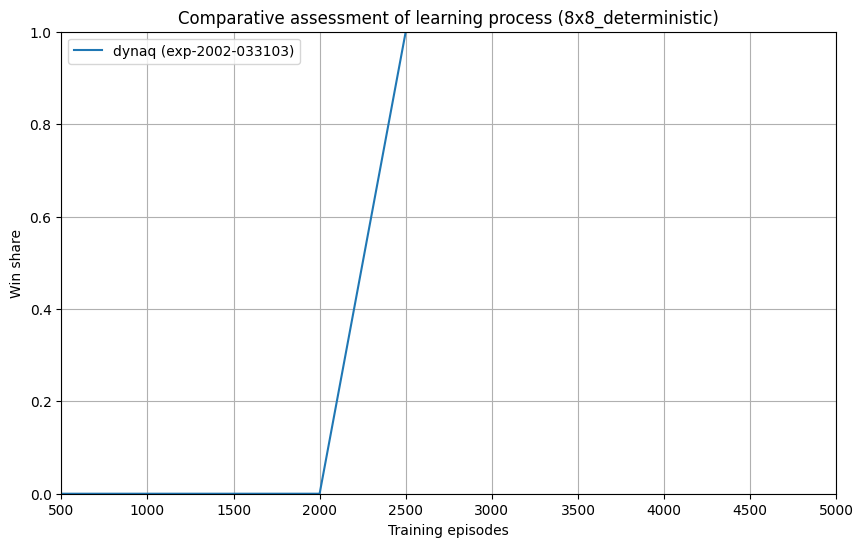

In [44]:
scenario_name = exp_params['scenario_name']
exp_ids = {
    exp_params['algorithm_name']: [exp_params['exp_id']]
}

display_validation_plot(scenarios_dir, scenario_name, exp_ids)

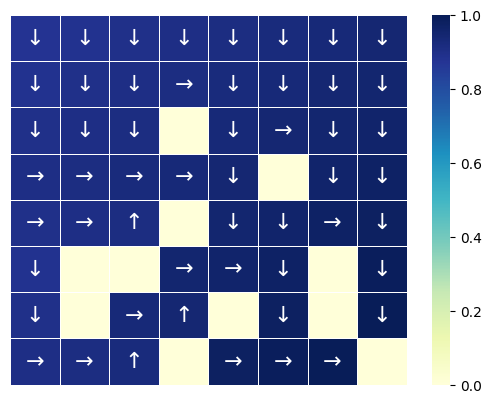

In [45]:
dynaq_agent.display_q_table()

In [46]:
dynaq_agent.display_model()

Transitions tabel:



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
L,0,0,1,2,3,4,5,6,8,8,9,10,11,12,13,14,16,16,17,0,19,20,21,22,24,24,25,26,27,0,29,30,32,32,33,0,35,36,37,38,40,0,0,42,43,44,0,46,48,0,49,50,0,52,0,54,56,56,57,0,59,60,61,0
D,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,0,28,29,30,31,32,33,34,35,36,0,38,39,40,41,42,0,44,45,46,47,48,0,0,51,52,53,0,55,56,0,58,59,0,61,0,63,56,57,58,0,60,61,62,0
R,1,2,3,4,5,6,7,7,9,10,11,12,13,14,15,15,17,18,19,0,21,22,23,23,25,26,27,28,29,0,31,31,33,34,35,0,37,38,39,39,41,0,0,44,45,46,0,47,49,0,51,52,0,54,0,55,57,58,59,0,61,62,63,0
U,0,1,2,3,4,5,6,7,0,1,2,3,4,5,6,7,8,9,10,0,12,13,14,15,16,17,18,19,20,0,22,23,24,25,26,0,28,29,30,31,32,0,0,35,36,37,0,39,40,0,42,43,0,45,0,47,48,49,50,0,52,53,54,0




Rewards tabel:



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
L,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
D,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
R,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
U,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Оценка агента

In [47]:
env = create_environment(map_size=MAP_SIZE, stochastic_env=STOCHASTIC_ENV)
evaluate_agent(env, dynaq_agent, exp_params, exp_dirs)
env.close()

EPISODE # 1
Agent reached the Goal 🏆
Number of steps: 14
--------------------------------------------------
EPISODE # 2
Agent reached the Goal 🏆
Number of steps: 14
--------------------------------------------------
EPISODE # 3
Agent reached the Goal 🏆
Number of steps: 14
--------------------------------------------------


In [48]:
show_episode_records(exp_dirs['evaluation'])

## Тестирование Q-агента в стохастической среде

In [122]:
MAP_SIZE = 8
STOCHASTIC_ENV = True

### Параметры эксперимента

In [123]:
exp_params = {
    'scenario_name': f'{MAP_SIZE}x{MAP_SIZE}_{"stochastic" if STOCHASTIC_ENV else "deterministic"}',
    'algorithm_name': 'qtable',
    'exp_id': f'exp-{datetime.now(TZ).strftime("%d%m-%H%M%S")}',
    'seed': 21,
    'training': {
        'iteration_count': 5,
        'episode_count': 5000,
        'learning_rate': 0.05,
        'gamma': 0.99,
        'epsilon': 1.0,
        'epsilon_min': 0.01,
        'epsilon_decay_rate': 0.99995
    },
    'validation': {
        'validate_agent_every_n_eps': 500,
        'episode_count': 10
    },
    'evaluation': {
        'episode_count': 3
    }
}

exp_dirs = create_exp_dirs(scenarios_dir, exp_params)
save_exp_params(exp_params, exp_dirs['exp'])

### Обучение агента

In [124]:
env = create_environment(map_size=MAP_SIZE, stochastic_env=STOCHASTIC_ENV)

for iter_num in range(1, exp_params['training']['iteration_count']+1):
    print(f'TRAINING ITERATION # {iter_num}\n')
    qtable_agent = QAgent(env, exp_params)
    train_agent(env, qtable_agent, exp_params, exp_dirs, enable_eps_recording=True)
    if iter_num != exp_params['training']['iteration_count']:
        clear_output()

env.close()

TRAINING ITERATION # 5

EPISODE # 500 / 5000
Win share (10 eps): 0.0
Avg step count (10 eps): 100.0
Aget exploration level (epsilon): 0.975
--------------------------------------------------
EPISODE # 1000 / 5000
Win share (10 eps): 0.0
Avg step count (10 eps): 100.0
Aget exploration level (epsilon): 0.951
--------------------------------------------------
EPISODE # 1500 / 5000
Win share (10 eps): 0.0
Avg step count (10 eps): 39.8
Aget exploration level (epsilon): 0.928
--------------------------------------------------
EPISODE # 2000 / 5000
Win share (10 eps): 0.0
Avg step count (10 eps): 36.4
Aget exploration level (epsilon): 0.905
--------------------------------------------------
EPISODE # 2500 / 5000
Win share (10 eps): 0.2
Avg step count (10 eps): 43.2
Aget exploration level (epsilon): 0.882
--------------------------------------------------
EPISODE # 3000 / 5000
Win share (10 eps): 0.0
Avg step count (10 eps): 32.4
Aget exploration level (epsilon): 0.861
------------------------

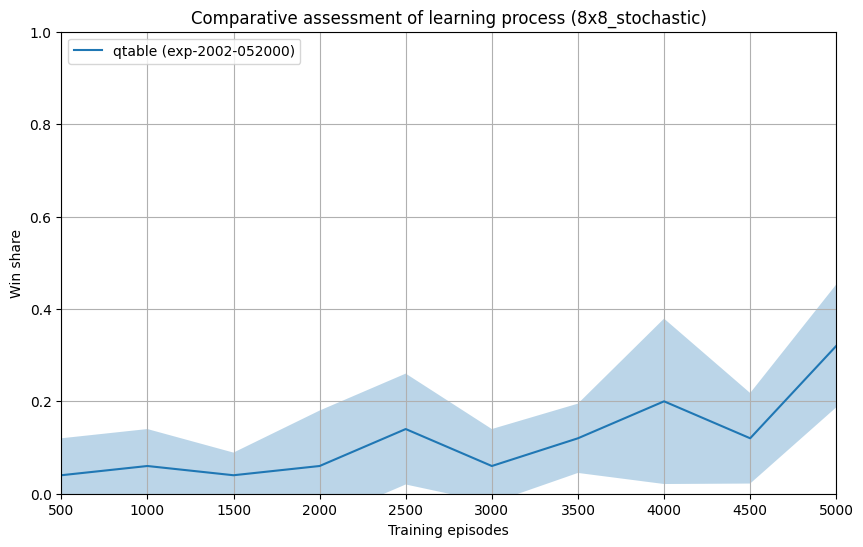

In [125]:
scenario_name = exp_params['scenario_name']
exp_ids = {
    exp_params['algorithm_name']: [exp_params['exp_id']]
}

display_validation_plot(scenarios_dir, scenario_name, exp_ids)

In [ ]:
# Видно, что классический Q-learning испытывает трудности в стохастических средах и не обеспечивает не слишком высокий winrate по статистике
# Это связано , что уравнение обнавления функции в Q-learning предполагает, 
# что выполнение действия a в состоянии s всегда приводит к одному и тому же следующему состоянию и вознаграждению
#Обычный Q-learning не хранит вероятности переходов — он просто перезаписывает значения, теряя информацию о стохастике

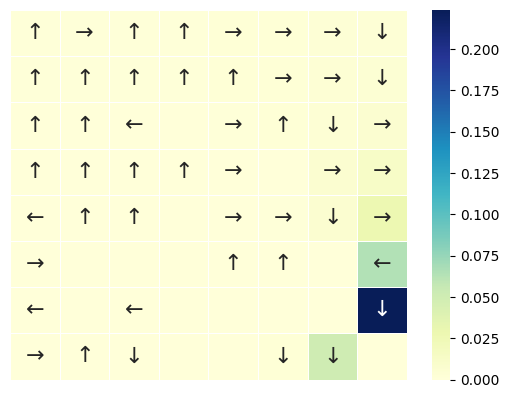

In [ ]:
qtable_agent.display_q_table() 

In [ ]:
# По факту обучения нет -  надежда , что позиция будет рядом с ящиком или просто повезет

### Оценка агента

In [127]:
train_eps_num = 3500

load_best_agent_for_train_step(train_eps_num,
                               exp_params['training']['iteration_count'],
                               exp_dirs['training'],
                               qtable_agent)

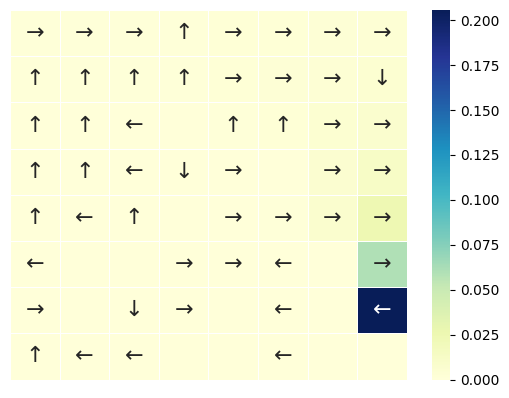

In [128]:
qtable_agent.display_q_table()

In [129]:
env = create_environment(map_size=MAP_SIZE, stochastic_env=STOCHASTIC_ENV)
evaluate_agent(env, qtable_agent, exp_params, exp_dirs)
env.close()

EPISODE # 1
Agent was defeated ☠️
Number of steps: 64
--------------------------------------------------
EPISODE # 2
Agent was defeated ☠️
Number of steps: 53
--------------------------------------------------
EPISODE # 3
Agent reached the Goal 🏆
Number of steps: 91
--------------------------------------------------


In [58]:
show_episode_records(exp_dirs['evaluation'])

## Тестирование DynaQ-агента в стохастической среде

In [131]:
MAP_SIZE = 8
STOCHASTIC_ENV = True

### Реализация модели окружения (Домашнее задание!)

Необходимо реализовать класс *StochasticEnvModel* для моделирования стохастической версии окружения, за основу можно взять класс *DeterministicEnvModel*.

In [133]:
class StochasticEnvModel:

    def __init__(self, n_states, n_actions):
        self.n_states = n_states
        self.n_actions = n_actions
        # Мы должны теперь учитывать не просто дейстие из стейта а вероятности действий и наград
        # нужен либо 3 мерный массив либо словарь в словаре - defaultdict[(state, action)][next_state] -> count
        self.transitions = defaultdict(self.default_transition)  # подсчет состояний (state, action) -> next_state
        self.rewards = defaultdict(self.default_reward)  # подсчет наград (state, action) -> reward


    def update(self, state, action, next_state, reward):
        # Update transition counts
        self.transitions[(state,action)][next_state] += 1
        # Update reward counts
        self.rewards[(state,action)][next_state].append(reward)
    
    def default_transition(self): #Нужно для десериализации
        return defaultdict(int)

    def default_reward(self): #Нужно для десериализации
        return defaultdict(list)
    
    @staticmethod # не хотим применять с self
    def weighted_sampling(state_probabilities):
        #Будем использовать дальше для взвешенного семплирвания с учетом вероятностей
        states = list(state_probabilities.keys())
        probabilities = list(state_probabilities.values())
        return random.choices(states, probabilities, k=1)[0]


    def sample(self):
        state_action = random.choice(list(self.transitions.keys())) # получаеся наш семпл  (state,action)
        return state_action
  
        
    def step(self, state, action):
        # Convert defaultdict to a normal dict to avoid TypeError
        transition_counts = dict(self.transitions[(state, action)])
        # Sample next state based on transition probabilities
        next_state = self.weighted_sampling(transition_counts)
        # Get average reward for this (state, action) pair
        avg_reward = np.mean(self.rewards[(state, action)][next_state])
        return next_state, avg_reward



    def display_transitions(self):
        print("State-Action Transition Probabilities:")
        for (state, action), transitions in self.transitions.items():
            total = sum(transitions.values())
            probs = {s: count / total for s, count in transitions.items()}
            print(f"State {state}, Action {action} -> {probs}")

    def display_rewards(self):
        print("State-Action Average Rewards:")
        for (state, action), rewards in self.rewards.items():
            avg_reward = np.mean(rewards)
            print(f"State {state}, Action {action} -> {avg_reward}")

### Параметры эксперимента

In [134]:
exp_params = {
    'scenario_name': f'{MAP_SIZE}x{MAP_SIZE}_{"stochastic" if STOCHASTIC_ENV else "deterministic"}',
    'algorithm_name': 'dynaq',
    'exp_id': f'exp-{datetime.now(TZ).strftime("%d%m-%H%M%S")}',
    'seed': 21,
    'training': {
        'iteration_count': 5,
        'episode_count': 5000,
        'learning_rate': 0.05,
        'gamma': 0.99,
        'epsilon': 1.0,
        'epsilon_min': 0.01,
        'epsilon_decay_rate': 0.99995,
        'planning_steps': 30
    },
    'validation': {
        'validate_agent_every_n_eps': 500,
        'episode_count': 10
    },
    'evaluation': {
        'episode_count': 3
    }
}

exp_dirs = create_exp_dirs(scenarios_dir, exp_params)
save_exp_params(exp_params, exp_dirs['exp'])

### Обучение агента

In [135]:
env = create_environment(map_size=MAP_SIZE, stochastic_env=STOCHASTIC_ENV)

for iter_num in range(1, exp_params['training']['iteration_count']+1):
    print(f'TRAINING ITERATION # {iter_num}\n')
    dynaq_agent = DynaQAgent(env, StochasticEnvModel, exp_params)
    train_agent(env, dynaq_agent, exp_params, exp_dirs, enable_eps_recording=True)
    if iter_num != exp_params['training']['iteration_count']:
        clear_output()

env.close()

TRAINING ITERATION # 5

EPISODE # 500 / 5000
Win share (10 eps): 0.0
Avg step count (10 eps): 100.0
Aget exploration level (epsilon): 0.975
--------------------------------------------------
EPISODE # 1000 / 5000
Win share (10 eps): 0.0
Avg step count (10 eps): 100.0
Aget exploration level (epsilon): 0.951
--------------------------------------------------
EPISODE # 1500 / 5000
Win share (10 eps): 0.0
Avg step count (10 eps): 100.0
Aget exploration level (epsilon): 0.928
--------------------------------------------------
EPISODE # 2000 / 5000
Win share (10 eps): 0.3
Avg step count (10 eps): 70.0
Aget exploration level (epsilon): 0.905
--------------------------------------------------
EPISODE # 2500 / 5000
Win share (10 eps): 0.2
Avg step count (10 eps): 84.9
Aget exploration level (epsilon): 0.882
--------------------------------------------------
EPISODE # 3000 / 5000
Win share (10 eps): 0.5
Avg step count (10 eps): 82.1
Aget exploration level (epsilon): 0.861
-----------------------

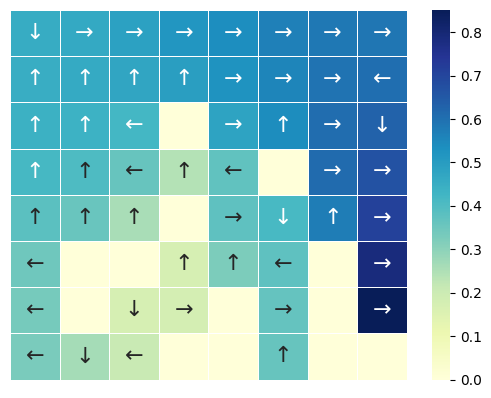

In [136]:
dynaq_agent.display_q_table()

In [ ]:
dynaq_agent.display_model()

In [120]:
exp_params['scenario_name']

'8x8_deterministic'

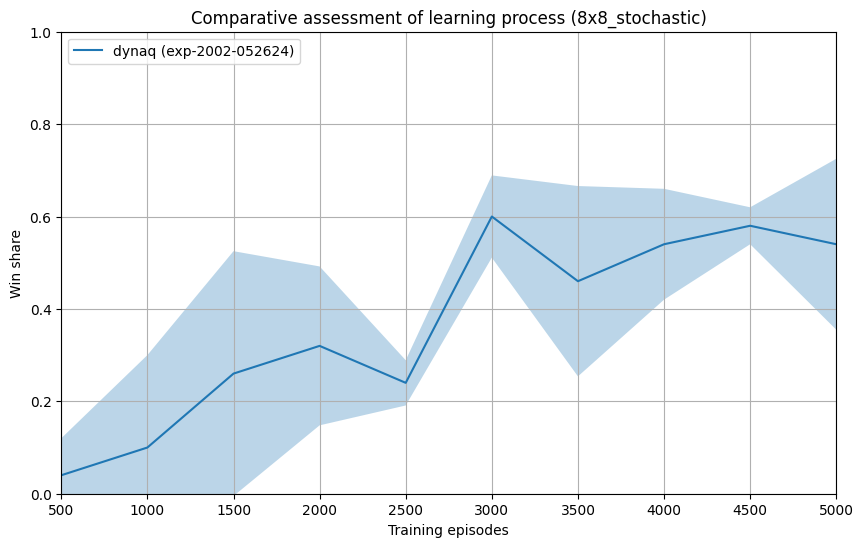

In [138]:
scenario_name = exp_params['scenario_name']
exp_ids = {
    exp_params['algorithm_name']: [exp_params['exp_id']]
}

display_validation_plot(scenarios_dir, scenario_name, exp_ids)

### Оценка агента

In [139]:
train_eps_num = 4000

load_best_agent_for_train_step(train_eps_num,
                               exp_params['training']['iteration_count'],
                               exp_dirs['training'],
                               dynaq_agent)

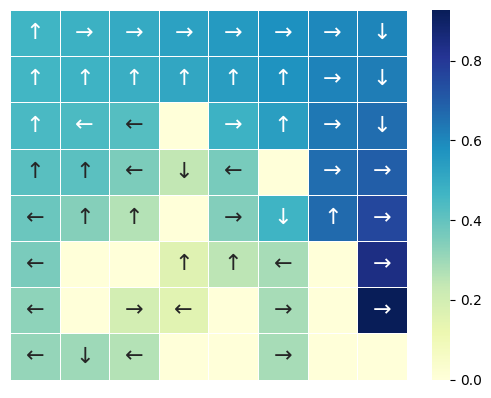

In [140]:
dynaq_agent.display_q_table()

In [143]:
env = create_environment(map_size=MAP_SIZE, stochastic_env=STOCHASTIC_ENV)
evaluate_agent(env, dynaq_agent, exp_params, exp_dirs)
env.close()

EPISODE # 1
Agent reached the Goal 🏆
Number of steps: 70
--------------------------------------------------
EPISODE # 2
Agent was defeated ☠️
Number of steps: 100
--------------------------------------------------
EPISODE # 3
Agent reached the Goal 🏆
Number of steps: 82
--------------------------------------------------


In [144]:
show_episode_records(exp_dirs['evaluation'])

## Сравнение эффективности процесса обучения

In [ ]:
scenario_name = '8x8_stochastic'
exp_ids = {
    'qtable': ['exp-1601-163730', 'exp-...'],
    'dynaq': ['exp-1601-170633']
}

display_validation_plot(scenarios_dir, scenario_name, exp_ids)

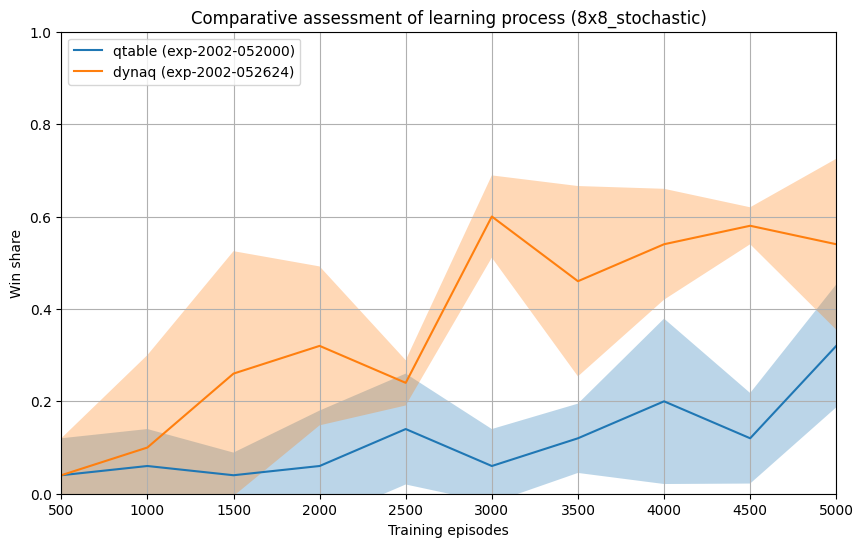

In [146]:
scenario_name = '8x8_stochastic'
exp_ids = {
    'qtable': ['exp-2002-052000'],
    'dynaq': ['exp-2002-052624']
}

display_validation_plot(scenarios_dir, scenario_name, exp_ids)

In [ ]:
#Видно, что вариант с DynaQ учится значительно быстрее и превосходит алгоритм Q-learning на всех шагах обучения
# Так как в нашем случае step возвращает случайный переход на основе эмпирических вероятностей, 
# что позволяет агенту постепенно оценить распределение переходов и наград, что делает его более устойчивым в стохастической среде
#Если планирование будет достаточно частым и количество шагов достаточным, агент сможет приблизить истинное распределение вероятностей